In [1]:
%matplotlib widget
import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../

import pylib.mix as mix
import pylib.measurement as mse
import est_qsvt as eqsvt
import pylib.qsvt_angles as qsvt_a

34261
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [9]:
# ----------------------------------------------------------------------------------
# --- Estimate the QSVT angles for the matrix inversion ---
# ----------------------------------------------------------------------------------
mix.reload_module(eqsvt)

# initial parameters:
id_case_ = 4
N_coefs_ = 20

kappa_goal_ = 10000. # estimate QSVT angles for the matrix inversion with kappa_qsvt = kappa_goal_

# read estimation parameters:
dd_ = eqsvt.read_estimation(id_case_, N_coefs_)

# estimation:
print()
print("--- Estimating the QSVT angles. ---")
phis_appr_, coef_norm_ = eqsvt.estimate_angles(dd_, kappa_goal_)

# print(len(phis_appr_))

Reading the coefficients from:
 ./tools/QSVT-angles/inversion//QSVT-MI-estimation-coefs-case4-Nc20.hdf5
When simulated:  02/05/2024: 18:37:43
Data for-inversion
kappa: 70.000
factor-norm: 0.125
N-env-half-neg: 798
N-env-half-pos: 797
N-coefs-envelop-neg: 20
N-coefs-envelop-pos: 20

--- Estimating the QSVT angles. ---
Na_rec-rec: 457256
Done.


N-angles: 457256
kappa: 10000.0
coef-norm: 1.250e-01

max. angle - np.pi/2: 1.250e-05
min. angle - np.pi/2: -1.250e-05
max-abs-err: 6.730e-05


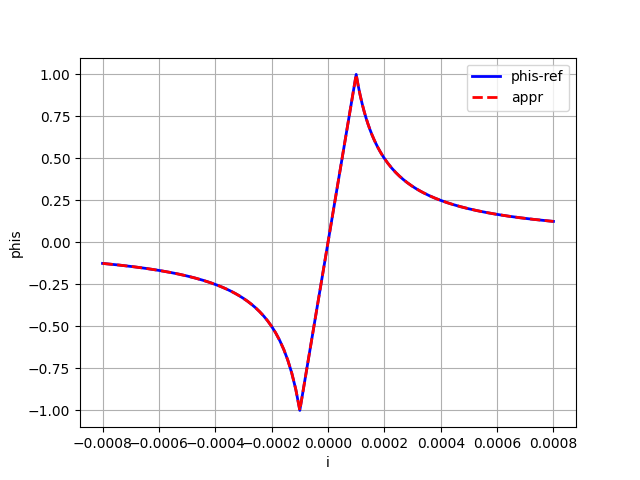

Done.


In [10]:
# ---------------------------------------------------------------------------------
# --- RECHECK: Compute the inverse function using the sequence of 2x2 rotations ---
# ---------------------------------------------------------------------------------
mix.reload_module(eqsvt)

eqsvt.construct_inverse_function(
    phis_appr_,
    kappa     = kappa_goal_, 
    coef_norm = coef_norm_
)
print("Done.")

In [ ]:
# --- for normalized signals ---
# kappa = 100:    1.269e-09
# kappa = 200:    1.614e-05
# kappa = 1000:   2.890e-05
# kappa = 4000:   3.071e-05
# kappa = 10000:  2.999e-05
# kappa = 100000: 1.214e-05

# --- for non-normalized signals ---
# kappa = 60000, err: 2.742e-04
# kappa = 10000, err: 5.323e-05
# kappa = 2000, err: 1.747e-05
# kappa = 1000, err: 1.254e-05  8.762e-04  9.801e-04

In [ ]:
# kappa = 4000, err: 1.701e-05
# kappa = 2000, err: 1.668e-05
# kappa = 400., err: 1.254e-05
# kappa = 200., err: 7.435e-06
# kappa = 100., err: 2.802e-06
# kappa = 50.0, err: 2.337e-05   

In [30]:
# ----------------------------------------------------------------
# --- Store the QSVT angles to .hdf5 file ---
# ----------------------------------------------------------------
# The stored angles can be use to compute the matrix inversion
# using the QSVT circuit.
# ---
# The condition number of the target matrix should be of the order of
# the parameter kappa_qsvt_.
# ----------------------------------------------------------------
from datetime import datetime
from datetime import date

def store_angles(phis):
    # --- Current time ---
    curr_time = date.today().strftime("%m/%d/%Y") + ": " + datetime.now().strftime("%H:%M:%S")

    # --- Create the filename ---
    str_log_eps = -int(np.floor(np.log10(max_norm_err_)))
    fname = "{:s}_{:d}_{:d}.hdf5".format("est_mi", int(kappa_qsvt_), str_log_eps)
    full_fname = path_root_ + "/" + fname

    # --- Store data ---
    print("write angles to:\n " + full_fname)
    with h5py.File(full_fname, "w") as f:
        grp = f.create_group("basic")
        grp.create_dataset('abs-error',    data=float(max_norm_err_))
        grp.create_dataset('date-of-simulation',  data=curr_time)
        grp.create_dataset('factor-norm',         data=float(coef_norm_))
        grp.create_dataset('function-parameter',  data=float(kappa_qsvt_))
        grp.create_dataset('function-parity', data=1)
        grp.create_dataset('function-type',   data="inv")
        grp.create_dataset('project-name',   data="est-mi")

        grp = f.create_group("results")
        grp.create_dataset('phis',  data = phis_save)
    return
# ---------------------------------------------------------------------------
# --- Correct the QSVT angles ---
phis_save = np.array(phis_appr)
# phis_save[0]  -= np.pi/4.
# phis_save[-1] -= np.pi/4.
# phis_save     += np.pi/2.

# --- Store the estimated QSVT angles for matrix inversion ---
store_angles(phis_save)

write angles to:
 ./tools/QSVT-angles/inversion//est_mi_2000_5.hdf5
